# Байесовские сети

**два слова, что это**

- Байесовская сеть = направленный граф + небольшие таблицы условных вероятностей.
- Она раскладывает большое совместное распределение на кусочки `P(ребёнок | родители)` и умеет отвечать на вопросы типа `P(дождь | вижу мокрую траву)`.

- Мини-история: 3 булевых события, стрелки `Cloudy → Rain → Umbrella`.
  - P(Cloudy)=0.30.
  - P(Rain | Cloudy)=0.60, P(Rain | ¬Cloudy)=0.20.
  - P(Umbrella | Rain)=0.90, P(Umbrella | ¬Rain)=0.10.

- Считаем: P(Rain)=0.30·0.60 + 0.70·0.20 = 0.32.
  Тогда P(Umbrella)=0.90·0.32 + 0.10·0.68 ≈ 0.36.
  
  Из тех же таблиц можно посчитать обратный запрос: если вижу зонт, вероятность дождя растёт.


**Зачем оно нам надо**

- здравоохранение: диагностика, оценка риска осложнений, объяснимость через граф;
- финансы: кредитное решение, фрод — можно явно моделировать причинные связи и смотреть условные вероятности;
- рекомендации/маркетинг: как факторы (сегмент, акция, сезон) влияют на покупку;
- системы с пропусками: можно выводить вероятности даже при неполных данных;
- обучение причинным связям: граф помогает объяснять, почему растёт/падает вероятность события.

**Мини-напоминание: теорема Байеса**

$P(A\mid B)=\dfrac{P(B\mid A)P(A)}{P(B)}$, где $P(B)=\sum\limits_j P(B\mid A_j)P(A_j)$.

В Байесовских сетях эту идею поднимаем на много переменных: раскладываем сложное совместное распределение на набор простых условных вероятностей.


**Что такое Байесовская сеть**
- Направленный ациклический граф (DAG): вершины — случайные переменные, рёбра — связи `родитель -> потомок`.
- Условная независимость: каждая переменная независима от всех неконтролируемых предков, если зафиксированы её родители.
- Факторизация: если у переменной $X_i$ родители $Pa(X_i)$, то 
$P(X_1,\dots,X_n)=\prod\limits_{i=1}^n P(X_i \mid Pa(X_i))$.
- Вместо огромной таблицы размеров `2^n` (для бинарных переменных) храним маленькие CPT (Conditional Probability Table) по родителям.
- Наивный Байес — частный случай: один родитель-класс и условная независимость признаков между собой.


**Игрушечный граф**

Три бинарные переменные: 
- `Rain` — идёт дождь?
- `Sprinkler` — полив включён?
- `WetGrass` — трава мокрая?
Рёбра: дождь влияет на полив (если дождь, полив почти не включают), и оба влияют на мокрую траву. Это классический пример из учебников.


In [1]:
%pip install -q pandas numpy matplotlib networkx


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import itertools, random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

random.seed(42)
np.random.seed(42)
pd.options.display.float_format = '{:.3f}'.format
plt.style.use('seaborn-v0_8-white')


**Рисуем граф**


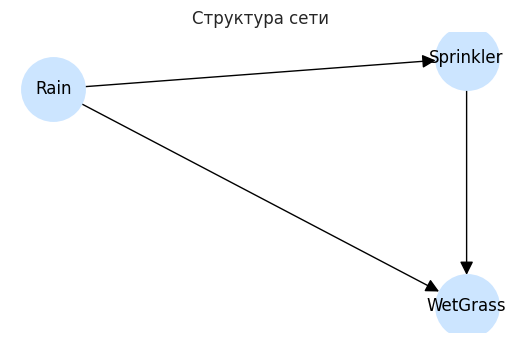

In [2]:
G = nx.DiGraph()
G.add_edges_from([('Rain', 'Sprinkler'), ('Rain', 'WetGrass'), ('Sprinkler', 'WetGrass')])

pos = {'Rain': (0.1, 0.9), 'Sprinkler': (1.0, 1.0), 'WetGrass': (1.0, 0.2)}
plt.figure(figsize=(5, 3))
nx.draw(G, pos=pos, with_labels=True, arrows=True, arrowstyle='-|>', arrowsize=20,
        node_color='#cce5ff', node_size=2000, linewidths=2)
plt.title('Структура сети')
plt.axis('off')
plt.show()


**CPT (таблицы условных вероятностей)**
Зададим разумные числа (их можно менять и смотреть на выводы):
- $P(Rain{=}True)=0.2$ (дожди нечастые).
- $P(Sprinkler{=}True\mid Rain{=}True)=0.01$, $P(Sprinkler{=}True\mid Rain{=}False)=0.40$ (если дождь, полив почти не включают).
- $P(WetGrass{=}True\mid Rain, Sprinkler)$: если хотя бы что-то есть, трава почти всегда мокрая; если ничего — редкая утренняя роса 0.05.


In [ ]:
import itertools

parents = {
    'Rain': [],
    'Sprinkler': ['Rain'],
    'WetGrass': ['Rain', 'Sprinkler'],
}

topo_order = ['Rain', 'Sprinkler', 'WetGrass']  # порядок без родителей слева

cpt = {
    'Rain': {(): {True: 0.20, False: 0.80}},
    'Sprinkler': {
        (True,): {True: 0.01, False: 0.99},
        (False,): {True: 0.40, False: 0.60},
    },
    'WetGrass': {
        (True, True): {True: 0.99, False: 0.01},
        (True, False): {True: 0.90, False: 0.10},
        (False, True): {True: 0.90, False: 0.10},
        (False, False): {True: 0.05, False: 0.95},
    },
}

def joint_probability(assignment: dict) -> float:
    """
    assignment — полный набор значений {'Rain': True, ...}.
    """
    prob = 1.0
    for node in topo_order:
        parent_vals = tuple(assignment[p] for p in parents[node])
        prob *= cpt[node][parent_vals][assignment[node]]
    return prob

def probability(query: dict, evidence: dict | None = None) -> float:
    """ полный перебор: P(query | evidence).
    query и evidence — словари вида {'Rain': True}.
    """
    evidence = evidence or {}

    def matches(assign: dict, cond: dict) -> bool:
        return all(assign[var] == val for var, val in cond.items())

    numerator = 0.0
    denominator = 0.0
    for values in itertools.product([True, False], repeat=len(topo_order)):
        assign = dict(zip(topo_order, values))
        jp = joint_probability(assign)
        if matches(assign, evidence):
            denominator += jp
            if matches(assign, query):
                numerator += jp
    return numerator / denominator

# сумма по всем сценариям  1
total = 0.0
for values in itertools.product([True, False], repeat=len(topo_order)):
    total += joint_probability(dict(zip(topo_order, values)))
print(f'Проверка нормировки P(...)=1: {total:.5f}')


Проверка нормировки P(...)=1: 1.00000


**Ручной вывод нескольких вероятностей**

Используем функцию `probability`, которая делает полный перебор (экспонента, но для трёх переменных нормально).


In [5]:
p_wet = probability({'WetGrass': True})
p_rain_and_wet = probability({'Rain': True, 'WetGrass': True})
p_rain_given_wet = probability({'Rain': True}, {'WetGrass': True})
p_sprinkler_given_wet = probability({'Sprinkler': True}, {'WetGrass': True})

print(f'P(WetGrass=True) = {p_wet:.4f}')
print(f'P(Rain=True, WetGrass=True) = {p_rain_and_wet:.4f}')
print(f'P(Rain=True | WetGrass=True) = {p_rain_given_wet:.4f}')
print(f'P(Sprinkler=True | WetGrass=True) = {p_sprinkler_given_wet:.4f}')

scenario = {'Rain': True, 'Sprinkler': False, 'WetGrass': True}
print(f"P(Rain=True, Sprinkler=False, WetGrass=True) = {joint_probability(scenario):.4f}")


P(WetGrass=True) = 0.4922
P(Rain=True, WetGrass=True) = 0.1802
P(Rain=True | WetGrass=True) = 0.3661
P(Sprinkler=True | WetGrass=True) = 0.5892
P(Rain=True, Sprinkler=False, WetGrass=True) = 0.1782


**Сэмплируем данные из сети**

Сделаем небольшую выборку, чтобы показать, как затем восстанавливаются CPT по частотам (это и есть MLE для категориальных переменных).


In [6]:
def sample_case() -> dict:
    case = {}

    case['Rain'] = random.random() < cpt['Rain'][()][True]
    spr_parent = (case['Rain'],)
    case['Sprinkler'] = random.random() < cpt['Sprinkler'][spr_parent][True]
    wet_parent = (case['Rain'], case['Sprinkler'])
    case['WetGrass'] = random.random() < cpt['WetGrass'][wet_parent][True]
    return case

data = pd.DataFrame(sample_case() for _ in range(500))
data.head()


,Rain,Sprinkler,WetGrass
0,False,True,True
1,False,False,False
2,False,True,True
3,True,False,True
4,True,False,True


**Оценим CPT по данным (частоты)**

Для категориальных переменных MLE — это просто относительные частоты. Посмотрим, насколько оценки близки к истинным параметрам, из которых мы сэмплировали.


Оценка P(Rain):


Rain
False   0.842
True    0.158
Name: P(Rain), dtype: float64

Оценка P(Sprinkler | Rain): строки — Rain, столбцы — Sprinkler


Sprinkler,False,True
Rain,,
False,0.589,0.411
True,1.000,0.000


Оценка P(WetGrass | Rain, Sprinkler):


P(WetGrass=True)
Rain  Sprinkler                  
False False                 0.044
      True                  0.908
True  False                 0.911

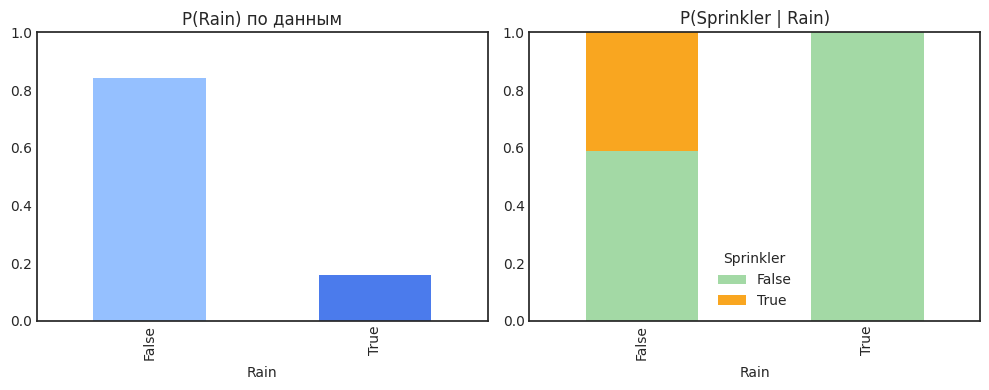

In [7]:
# P(Rain)
rain_hat = data['Rain'].value_counts(normalize=True).rename('P(Rain)')
print('Оценка P(Rain):')
display(rain_hat)

# P(Sprinkler | Rain)
spr_table = pd.crosstab(data['Rain'], data['Sprinkler'], normalize='index')
print('Оценка P(Sprinkler | Rain): строки — Rain, столбцы — Sprinkler')
display(spr_table)

# P(WetGrass | Rain, Sprinkler)
wet_table = (data.groupby(['Rain', 'Sprinkler'])['WetGrass']
                    .value_counts(normalize=True)
                    .rename('prob')
                    .reset_index()
                    .query('WetGrass == True')
                    .pivot(index=['Rain', 'Sprinkler'], columns='WetGrass', values='prob'))
wet_table.columns = ['P(WetGrass=True)']
print('Оценка P(WetGrass | Rain, Sprinkler):')
display(wet_table)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
rain_hat.sort_index().plot(kind='bar', ax=axes[0], color=['#95c0ff', '#4b7bec'])
axes[0].set_title('P(Rain) по данным')
axes[0].set_ylim(0, 1)
spr_table.plot(kind='bar', stacked=True, ax=axes[1], color=['#a3d9a5', '#f9a620'])
axes[1].set_title('P(Sprinkler | Rain)')
axes[1].set_ylim(0, 1)
axes[1].legend(title='Sprinkler')
plt.tight_layout()
plt.show()


**Сравним вывод по модели и по выборке**

Посчитаем $P(Rain{=}True \mid WetGrass{=}True)$ двумя способами: 
1) аналитически через CPT (функция `probability`)
2) частотой в данных.


In [8]:
def conditional_from_data(df: pd.DataFrame, target: str, evidence: dict) -> float:
    mask = pd.Series(True, index=df.index)
    for var, val in evidence.items():
        mask &= df[var] == val
    subset = df[mask]
    return (subset[target] == True).mean()

p_rain_given_wet_data = conditional_from_data(data, 'Rain', {'WetGrass': True})
p_rain_given_wet_model = probability({'Rain': True}, {'WetGrass': True})

print(f'Из выборки: P(Rain=True | WetGrass=True) ≈ {p_rain_given_wet_data:.4f}')
print(f'Из модели (CPT): P(Rain=True | WetGrass=True) = {p_rain_given_wet_model:.4f}')
print(f'Разница из-за конечного размера выборки ≈ {p_rain_given_wet_data - p_rain_given_wet_model:.4f}')


Из выборки: P(Rain=True | WetGrass=True) ≈ 0.3000
Из модели (CPT): P(Rain=True | WetGrass=True) = 0.3661
Разница из-за конечного размера выборки ≈ -0.0661


**Задача ЛР:**

Нам нужно показать, что мы понимаем, как из табличных данных руками построить простую Байесовскую сеть. 
После выполнения лабораторной у нас должно быть: 
(а) граф зависимостей, 

(б) таблицы условных вероятностей (CPT) по данным 

(в) несколько рассчитанных условных вероятностей с пояснением. 


**Шаг 0. Загружаем (или создаём) табличку**

Для примера построим мини-датасет про выдачу кредита

In [ ]:
toy_df = pd.DataFrame({
    'income': [70000, 35000, 90000, 55000, 30000, 80000, 62000, 45000],
    'history': ['good', 'bad', 'good', 'good', 'bad', 'good', 'good', 'bad'],
    'age': [29, 48, 41, 33, 26, 52, 37, 31],
    'approved': [1, 0, 1, 1, 0, 1, 1, 0],
})
toy_df

,income,history,age,approved
0,70000,good,29,1
1,35000,bad,48,0
2,90000,good,41,1
3,55000,good,33,1
4,30000,bad,26,0
5,80000,good,52,1
6,62000,good,37,1
7,45000,bad,31,0


**Шаг 1. Готовим бинарные признаки**

Сети проще кормить булевыми переменными (True/False)
В своей работе порог можно выбрать другой, либо заранее закодировать категориальные значения


In [11]:
df = toy_df.copy()
df['HighIncome'] = df['income'] >= 60000
df['GoodHistory'] = df['history'] == 'good'
df['AgeAbove35'] = df['age'] >= 35
df['Approved'] = df['approved'] == 1
df = df[['HighIncome', 'GoodHistory', 'AgeAbove35', 'Approved']]
df

,HighIncome,GoodHistory,AgeAbove35,Approved
0,True,True,False,True
1,False,False,True,False
2,True,True,True,True
3,False,True,False,True
4,False,False,False,False
5,True,True,True,True
6,True,True,True,True
7,False,False,False,False


**Шаг 2. Задаём структуру графа**

Рассказываем словами, какие факторы влияют на целевую переменную (одобрение)

Рисуем DAG, чтобы визуально показать зависимость.

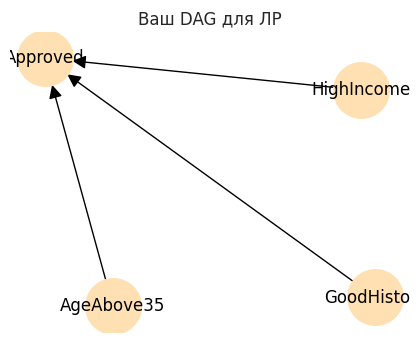

In [13]:
edges = [
    ('HighIncome', 'Approved'),
    ('GoodHistory', 'Approved'),
    ('AgeAbove35', 'Approved'),
]
G_lab = nx.DiGraph(edges)
plt.figure(figsize=(4, 3))
nx.draw(G_lab, with_labels=True, node_color='#ffe0b2', node_size=1600,
        arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title('Ваш DAG для ЛР')
plt.axis('off')
plt.show()


**Шаг 3. Строим CPT из данных**

Для каждой комбинации родителей (строки таблицы) считаем частоты целевой переменной. 

Используем `pd.crosstab` с `normalize='index'`.

Здесь CPT показывает, насколько вероятно одобрение при разных сочетаниях дохода/истории/возраста.


In [15]:
cpt_approved = pd.crosstab(
    [df['HighIncome'], df['GoodHistory'], df['AgeAbove35']],
    df['Approved'],
    normalize='index'
)
cpt_approved.columns = ['P(Approved=False)', 'P(Approved=True)']
cpt_approved

P(Approved=False)  P(Approved=True)
HighIncome GoodHistory AgeAbove35                                     
False      False       False                   1.000             0.000
                       True                    1.000             0.000
           True        False                   0.000             1.000
True       True        False                   0.000             1.000
                       True                    0.000             1.000

**Шаг 4. Считаем конкретные условные вероятности**

Выводим несколько чисел, чтобы показать, как интерпретировать сеть: 

например, "если доход высокий, шанс одобрения такой-то". Эти же запросы можно потом сравнить с настоящей сетью

In [16]:
p_approved_given_income = (df['Approved'] & df['HighIncome']).mean() / df['HighIncome'].mean()
p_approved_given_goodhist = (df['Approved'] & df['GoodHistory']).mean() / df['GoodHistory'].mean()
print(f"P(Approved=True | HighIncome=True) ≈ {p_approved_given_income:.2f}")
print(f"P(Approved=True | GoodHistory=True) ≈ {p_approved_given_goodhist:.2f}")
print('Дальше можно добавить любые запросы, которые кажутся важными для предметной области.')

P(Approved=True | HighIncome=True) ≈ 1.00
P(Approved=True | GoodHistory=True) ≈ 1.00
Дальше можно добавить любые запросы, которые кажутся важными для предметной области.


**Что приложить в отчёт**
1. Скрин/рисунок вашего графа зависимости.
2. Таблицу CPT (хотя бы для целевой переменной).
3. Пояснения по условным вероятностям ("при таких условиях шанс события столько-то, это логично, потому что ...").
4. Пару предложений о том, что нового сеть позволяет заметить в данных.


**Домашнее задание (ЛР)**
1. Выберите датасет (можно взять пример https://www.kaggle.com/code/ademox02/bayesian-networks или любой свой — за свой +1 балл).
2. Оставьте категориальных/бинарных переменных, объясните словами, какие зависимости между ними ожидаете.
3. Нарисуйте структуру DAG (можно `networkx`)
4. Постройте CPT по данным
5. Посчитайте 2–3 условных вероятности. Например, $P(A\mid B)$, $P(A\mid B, C)$, и сравните их с интуицией.
6. Кратко интерпретируйте: что даёт сеть, какие зависимости/независимости видите.

Формат сдачи: ноутбук с кодом + картинка графа (можно в самом ноутбуке).